In [1]:
import numpy as np
import cv2 as cv
from skimage.feature import canny
from skimage.feature import local_binary_pattern, hog
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

import joblib

In [2]:
def face_recognition(image_path):
    # Memuat Haar Cascade untuk deteksi wajah manusia atau kucing (Jika ada)
    # cascade_wajah = cv.CascadeClassifier('/content/drive/MyDrive/PCVK_2024/Images/haarcascades/haarcascade_frontalface_default.xml')
    cascade_wajah = cv.CascadeClassifier('input_output/haarcascade_frontalface_default.xml')

    # Membaca Gambar
    image = cv.imread(image_path)

    # Mengubah gambar menjadi grayscale
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    # scaleFactor: Faktor skala untuk memperkecil gambar setiap proses deteksi.
    # minNeighbors: Jumlah minimum tetangga yang diperlukan untuk validasi objek.
    # minSize: Ukuran minimum objek yang akan dideteksi.
    faces = cascade_wajah.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Wajah tidak terdeteksi
    if len(faces) == 0:
        print("Wajah tidak terdeteksi!")
        return None

    # Memproses setiap wajah yang terdeteksi
    for (x, y, w, h) in faces:
        # Memotong gambar sesuai area deteksi wajah
        face_crop = image[y:y+h, x:x+w]

    return face_crop

In [ ]:
def preprocess_image(image_path, target_size=(200, 200)):
    """
    Preprocesses an image by detecting a face, cropping it, and resizing it.

    Parameters:
    - image_path: Path to the input image.
    - target_size: Tuple of integers (width, height) specifying the output image size.

    Returns:
    - preprocessed_image: The cropped and resized face image. Returns None if no face is detected.
    """
    # Memuat Haar Cascade untuk deteksi wajah
    cascade_wajah = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Membaca gambar
    image = cv.imread(image_path)
    if image is None:
        print("Gambar tidak ditemukan!")
        return None

    # Mengubah gambar menjadi grayscale
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    # Deteksi wajah
    faces = cascade_wajah.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Jika tidak ada wajah terdeteksi, kembalikan None
    if len(faces) == 0:
        print("Wajah tidak terdeteksi!")
        return None

    # Memotong gambar sesuai area deteksi wajah (ambil wajah pertama yang terdeteksi)
    x, y, w, h = faces[0]  # Mengambil wajah pertama
    face_crop = image[y:y+h, x:x+w]

    # Mengubah ukuran gambar ke target_size (200x200)
    preprocessed_image = cv.resize(face_crop, target_size)

    return preprocessed_image

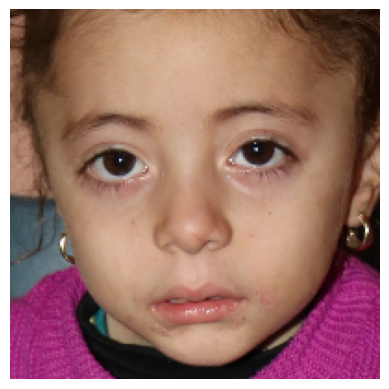

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Fungsi untuk mendeteksi wajah dan memotong gambar
def preprocess_image(image_path, target_size=(200, 200)):
    # Membaca gambar
    image = cv2.imread(image_path)
    
    # Mengonversi gambar ke grayscale untuk deteksi wajah
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Memuat classifier deteksi wajah dari OpenCV
    face_cascade = cv.CascadeClassifier('input_output/haarcascade_frontalface_default.xml')
    
    # Mendeteksi wajah di gambar
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) == 0:
        print("Tidak ada wajah yang terdeteksi!")
        return None  # Kembalikan None jika tidak ada wajah yang terdeteksi

    # Mengambil wajah pertama yang terdeteksi
    (x, y, w, h) = faces[0]
    
    # Memotong gambar untuk hanya mengambil wajah
    face_image = image[y:y+h, x:x+w]
    
    # Meresize gambar ke ukuran target
    face_image_resized = cv2.resize(face_image, target_size)
    
    return face_image_resized

# Path gambar yang ingin diproses
image_path = 'assets/test/0/20.jpg'

# Proses gambar
preprocessed_image = preprocess_image(image_path, target_size=(200, 200))

# Jika gambar berhasil diproses, tampilkan hasilnya
if preprocessed_image is not None:
    plt.imshow(cv2.cvtColor(preprocessed_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
    plt.axis('off')  # Menyembunyikan axis
    plt.show()
else:
    print("Gagal memproses gambar!")


In [4]:
# Parameters
IMAGE_SIZE = (200, 200)  # Resize all images to 200x200
LBP_RADIUS = 3          # Radius for LBP
LBP_POINTS = 8 * LBP_RADIUS  # Number of points for LBP

In [5]:
def extract_lbp_features(image):
    """Extract LBP features from an image."""
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, LBP_POINTS, LBP_RADIUS, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, LBP_POINTS + 3),
                             range=(0, LBP_POINTS + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist

In [6]:
def extract_hog_features(image):
    """Extract HOG features from an image."""
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    features = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), block_norm='L2-Hys', transform_sqrt=True)
    return features

In [7]:
def classify_image(image_path, model, augment=False):
    """
    Classifies an image using a pre-trained model with both LBP and HOG feature extraction.

    Parameters:
    - image_path: Path to the image to classify.
    - model: The pre-trained classification model.
    - augment: Boolean flag to apply augmentations (if needed).

    Returns:
    - The predicted label of the image.
    """
    # Preprocessing gambar: deteksi wajah, crop, dan resize
    preprocessed_image = preprocess_image(image_path, target_size=(200, 200))

    # Jika preprocessing gagal (misal wajah tidak terdeteksi), kembalikan None atau pesan
    if preprocessed_image is None:
        return "Gagal memproses gambar!"

    # Ekstraksi fitur LBP dan HOG
    lbp_features = extract_lbp_features(preprocessed_image)
    hog_features = extract_hog_features(preprocessed_image)

    # Gabungkan fitur menjadi satu vektor
    features = np.hstack((lbp_features, hog_features))

    # Reshape vektor fitur untuk prediksi
    features = features.reshape(1, -1)

    # Gunakan model untuk memprediksi label
    label = model.predict(features)[0]
    return label


In [8]:
import matplotlib.pyplot as plt

# Fungsi untuk menampilkan gambar dengan ukuran lebih kecil
def display_image(image, title="Image", figsize=(10, 10)):
    plt.figure(figsize=figsize)
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

In [9]:
# Defining a function to return the class labels corresponding to age-ranges
def class_labels(age):
    if 0 <= age <= 12:
        return 0
    elif 13 <= age <= 20:
        return 1
    elif 21 <= age <= 30:
        return 2
    elif 31 <= age <= 40:
        return 3
    elif 41 <= age <= 50:
        return 4
    else:
        return 5

In [10]:
import os
import pandas as pd
import joblib
from sklearn.metrics import accuracy_score
import cv2

# Fungsi untuk membaca dataset lokal dan menyiapkan filepath serta label
def load_dataset(folder_path):
    data = []
    for root, _, files in os.walk(folder_path):
        for file_name in files:
            if file_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                file_path = os.path.join(root, file_name)
                # Ekstrak label dari angka sebelum ekstensi
                # Ekstrak label 
                age = int(file_name.split('_')[0])  # Extract age from filename
                label = class_labels(age)  # Convert age to class label
                data.append((file_path, label))  # Path dan label
    return pd.DataFrame(data, columns=['filepath', 'label'])

# Fungsi untuk memproses dataset dan menghitung akurasi
def evaluate_model(folder_path, model):
    data = load_dataset(folder_path)
    y_true = []
    y_pred = []

    for _, row in data.iterrows():
        image_path = row['filepath']
        true_label = row['label']

        # Prediksi dengan LBP dan HOG (tanpa augmentasi)
        predicted_label = classify_image(image_path, model, augment=False)
        
        # Menambahkan hasil prediksi ke daftar
        y_true.append(true_label)
        y_pred.append(predicted_label)

    # Hitung akurasi
    accuracy = accuracy_score(y_true, y_pred)
    return accuracy, y_true, y_pred

# Path dataset lokal
train_folder = 'dataset/final_dataset/train'
test_folder = 'dataset/final_dataset/test'

# Memuat model
model_path = "model/xgb_model_acc_0.68.pkl"
model_xgb = joblib.load(model_path)

# Evaluasi model dengan dataset test
accuracy, y_true, y_pred = evaluate_model(test_folder, model_xgb)

# Tampilkan hasil
print(f"Akurasi Model: {accuracy * 100:.2f}%")

Akurasi Model: 37.39%


In [11]:
import os
import pandas as pd
import joblib
from sklearn.metrics import accuracy_score
import cv2

# Fungsi untuk membaca dataset lokal dan menyiapkan filepath serta label
# def load_dataset(folder_path):
#     data = []
#     for root, _, files in os.walk(folder_path):
#         for file_name in files:
#             if file_name.lower().endswith(('.jpg', '.jpeg', '.png')):
#                 file_path = os.path.join(root, file_name)
#                 # Ekstrak label dari angka sebelum ekstensi
#                 # Ekstrak label 
#                 age = int(file_name.split('_')[0])  # Extract age from filename
#                 label = class_labels(age)  # Convert age to class label
#                 data.append((file_path, label))  # Path dan label
#     return pd.DataFrame(data, columns=['filepath', 'label'])

# Fungsi untuk membaca dataset lokal dan menyiapkan filepath serta label
def load_dataset(folder_path):
    data = []
    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        if os.path.isdir(label_path):  # Pastikan hanya memproses folder
            for file_name in os.listdir(label_path):
                if file_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    file_path = os.path.join(label_path, file_name)
                    data.append((file_path, int(label)))  # Path dan label
    return pd.DataFrame(data, columns=['filepath', 'label'])

# Fungsi untuk memproses dataset dan menghitung akurasi
def evaluate_model(folder_path, model):
    data = load_dataset(folder_path)
    y_true = []
    y_pred = []

    for _, row in data.iterrows():
        image_path = row['filepath']
        true_label = row['label']

        # Prediksi dengan LBP dan HOG (tanpa augmentasi)
        predicted_label = classify_image(image_path, model, augment=False)
        
        # Menambahkan hasil prediksi ke daftar
        y_true.append(true_label)
        y_pred.append(predicted_label)

    # Hitung akurasi
    accuracy = accuracy_score(y_true, y_pred)
    return accuracy, y_true, y_pred

# Path dataset lokal
train_folder = 'assets/train/'
test_folder = 'assets/test/'

# Memuat model
model_path = "model/svc_model_acc_0.69.pkl"
model_xgb = joblib.load(model_path)

# Evaluasi model dengan dataset test
accuracy, y_true, y_pred = evaluate_model(test_folder, model_xgb)

# Tampilkan hasil
print(f"Akurasi Model: {accuracy * 100:.2f}%")

Akurasi Model: 16.67%


In [12]:
# # Memuat model
# model_path = "model/xgb_model_acc_0.68.pkl"
# model_xgb = joblib.load(model_path)

# # Evaluasi model dengan dataset test
# accuracy, y_true, y_pred = evaluate_model(test_folder, model_xgb)

# # Tampilkan hasil
# print(f"Akurasi Model: {accuracy * 100:.2f}%")